In [12]:
import os
import bilby
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm

In [19]:
### plot settings and colors
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Computer Modern Roman"
mpl.rcParams["font.size"] = 20
mpl.rcParams["text.usetex"] = True
mpl.rcParams["grid.alpha"] = 0

mpl.rcParams["figure.dpi"] = 300

# nice plotting colors
hybrid_color = "#3a0ca3"
hybrid_overlap0_color = "#b5179e"
nest0_color    = "#4895ef"

In [20]:
### relevant injected values
dpi_vals = dict(
    d_phi_0 = 0, d_phi_1 = 0, d_phi_2 = 0.2, d_phi_3 = 0, d_phi_4 = 0,
    d_phi_5L = 0, d_phi_6 = 0, d_phi_6L = 0, d_phi_7 = 0,
    d_alpha_2 = 0, d_alpha_3 = 0, d_alpha_4 = 0,
    d_beta_2 = 0, d_beta_3 = 0
)

chirp_mass = 30

In [21]:
def dpi_key_to_label(key):
    """ Helper method to convert dpi names in bilby labels, prior files, etc. 
    to a latex label; e.g. d_phi_2 -> $\\delta \\varphi_2$. """

    return (
        "$" + key.replace('d_', '\\delta \\')
        .replace('phi', 'varphi')
        .replace('5L', '{5l}')
        .replace('6L', '{6l}') + "$"
    )

# Read hybrid results

In [22]:
outdir = "/home/noah.wolfe/bgr_source_model/paper_runs/highsnr-bgr-injection/hybrid/hybrid-highsnr-bgr-injection"
label  = "hybrid-highsnr-bgr-injection"

queue_path = "/home/noah.wolfe/bgr_source_model/paper_runs/highsnr-bgr-injection/hybrid/queue.txt"

In [30]:
dpi_runs = dict()

with open(queue_path, "r") as dpi_run_file:
    for run in tqdm(dpi_run_file.readlines()):
        dpi, overlap = [ s.strip() for s in run.strip().split(",") ]
        result_path  = os.path.join(
            outdir, "result", 
            f"{label}_data0_0-0_analysis_H1L1_{dpi}_overlap-{overlap}_result.json"
        )

        if os.path.isfile(result_path):
            dpi_runs[(dpi, overlap, "hybrid")] = bilby.core.result.read_in_result(result_path)

100%|██████████| 28/28 [00:47<00:00,  1.68s/it]


# Read `dynesty`-only results

In [33]:
verif_parentdir = "/home/noah.wolfe/MA499_report_runs/injected/beyond-gr/SNR/beyond-gr_d_phi_2-2E-01_dL-100"

unique_dpi = set([ run[0] for run in dpi_runs ])

for dpi in tqdm(unique_dpi):
    verif_label = f"beyond-gr_d_phi_2-2E-01_dL-100_{dpi}_only-dynesty_no-overlap"
    verif_outdir = os.path.join(verif_parentdir, verif_label)
    if not os.path.isdir(verif_outdir):
        print(f"Missing a verification run outdir for {dpi}!")
        continue

    verif_resultpath = os.path.join(verif_outdir, "result", f"{verif_label}_data0_0-0_analysis_H1L1_dynesty_result.json")
    if not os.path.isfile(verif_resultpath):
        print(f"Missing a verification run result for {dpi}!")
        continue

    dpi_runs[(dpi, "0.0", "dynesty")] = bilby.core.result.read_in_result(verif_resultpath)

100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


# Violinplot

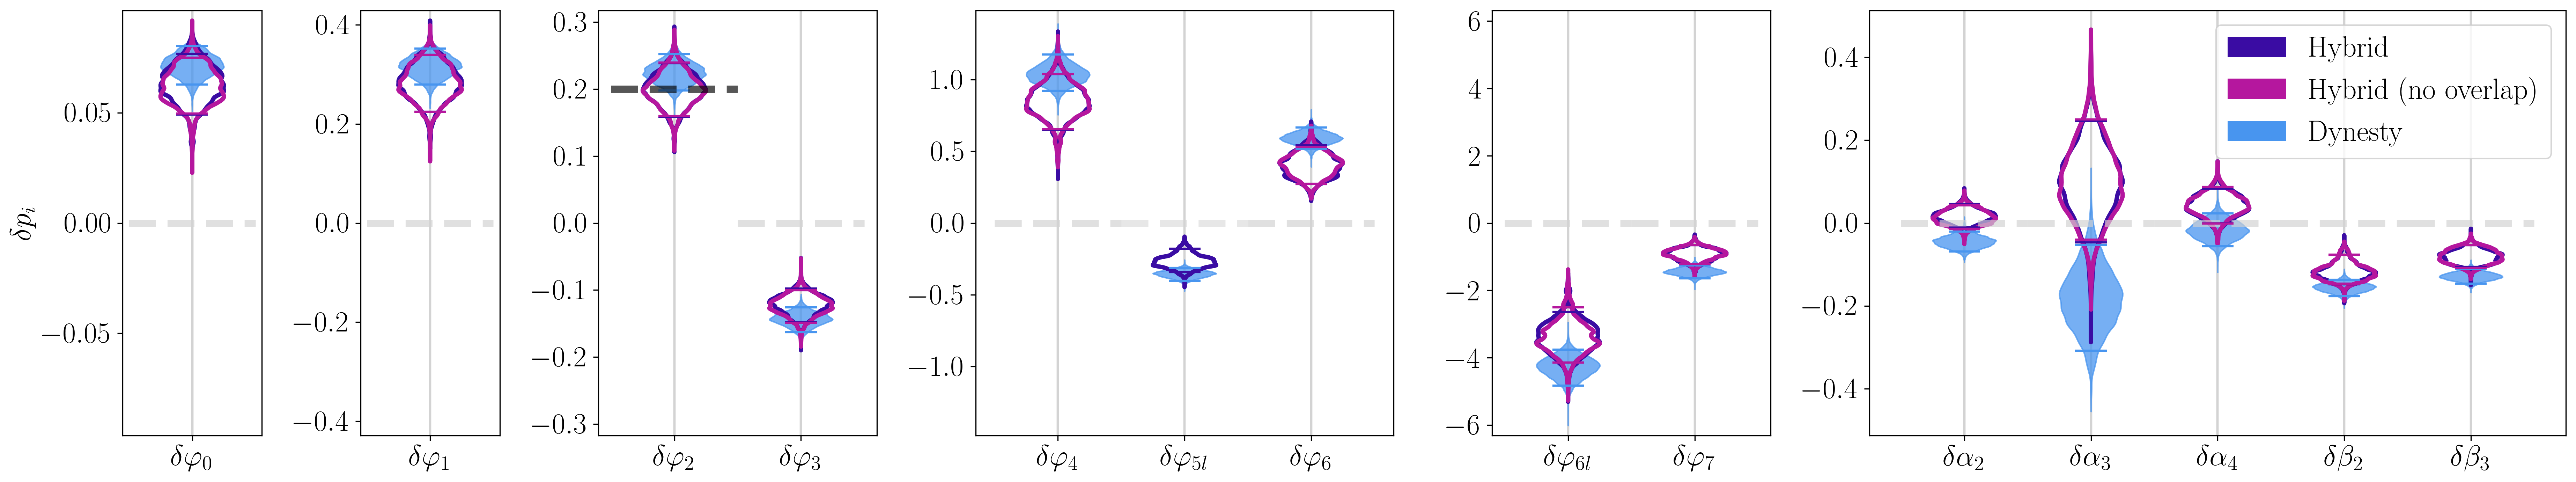

In [35]:
# which parameters to plot in which panels (from left to right column)
dpi_panels = [
    ["d_phi_0"], ["d_phi_1"], ["d_phi_2","d_phi_3"], 
    ["d_phi_4","d_phi_5L", "d_phi_6"], ["d_phi_6L", "d_phi_7"],
    ["d_alpha_2", "d_alpha_3", "d_alpha_4", "d_beta_2", "d_beta_3"] 
]
npanels = len(dpi_panels)

gs = mpl.gridspec.GridSpec(
    1, npanels,
    width_ratios = [ len(panel) for panel in dpi_panels ], 
)

fig = plt.figure(figsize=(25,5))
axes = [ fig.add_subplot(gs[i]) for i in range(npanels) ]

for run, result in reversed(dpi_runs.items()): # reversed plots overlap0 on top of 0.9 overlap runs
    dpi, overlap, runtype = run
    samples = result.samples[ :, result.search_parameter_keys.index(dpi) ]

    # set plotting colors and other parameters based on how the result was generated
    truth = dpi_vals[dpi]
    truth_color = "#d3d3d3" if truth == 0 else "black"

    if runtype == "dynesty":
        facecolor = nest0_color
        edgecolor = nest0_color
        linewidth = 1
        alpha = 0.75
    else:
        facecolor = "none"
        edgecolor = hybrid_color if float(overlap) > 0 else hybrid_overlap0_color
        linewidth = 3
        alpha = 1

    # select the ax object to plot in based on list in dpi_panels that dpi is in
    # use the integer index of dpi in that list as the x-axis position of the violin
    pidx, x = [ (i, panel.index(dpi)) for i,panel in enumerate(dpi_panels) if dpi in panel ][0]
    ax = axes[pidx]

    # truth line
    ax.hlines(
        truth, x - 0.5, x + 0.5, 
        colors=[truth_color], linestyles=["--"], linewidths=[5], alpha=[0.3] 
    )
    
    # vertical line, in light gray, to guide the eye (to correlate dpi label to plot)
    ax.axvline(x = x, color = "#d3d3d3", zorder = -1)

    # plot and format violin
    dists = ax.violinplot(samples, [x], quantiles=[0.05, 0.95], showextrema=False)
    for partname in ('cquantiles',):
        dists[partname].set_edgecolor(edgecolor)

    for pc in dists['bodies']:
        pc.set_facecolor(facecolor)
        pc.set_edgecolor(edgecolor)
        pc.set_linewidth(linewidth)
        pc.set_alpha(alpha)

# center y-axis on zero, label x-axis of each subplot
for panel, ax in zip(dpi_panels, axes):
    ymax = np.max(np.abs( list(ax.get_ylim()) ))
    ax.set_ylim(-ymax, ymax)

    ax.set_xticks([ i for i in range(len(panel)) ])
    ax.set_xticklabels([ dpi_key_to_label(dpi_key) for dpi_key in panel ])

axes[0].set_ylabel(r"$\delta p_i$")
axes[-1].legend(
    [ 
        mpl.patches.Patch(facecolor=hybrid_color), 
        mpl.patches.Patch(facecolor=hybrid_overlap0_color), 
        mpl.patches.Patch(facecolor=nest0_color) 
    ],
    [ "Hybrid", "Hybrid (no overlap)", "Dynesty" ]
)
    
plt.tight_layout()